In [32]:
import sys
import random
import numpy as np
import matplotlib.pyplot as plt

 ## some parameters: equivalent to those in MadGraph
pb_convert = 3.894E8 # conversion factor GeV^-2 -> pb
MZ = 91.188    # Z boson mass
GAMMAZ = 2.4414 # Z boson width
alpha = 1/132.507 # alpha QED
Gfermi = 1.16639E-5 # fermi constant
sw2 = 0.222246 # sin^2(weinberg angle)

# e+e- COM energy in GeV
ECM = 90
hats = ECM**2
print("e+e- com energy:", ECM, "GeV")


## define a function that gives the differential cross section
## as a function of the parameters
## we include anything that depends on s, even though in this case they are fixed for future use with variable s (hadron collisions)
def dsigma(costh):
    # CL and CR
    CV = -0.5 + 2 * sw2
    CA = -0.5
    # constants and functions that appear in the differential cross section
    kappa = np.sqrt(2) * Gfermi * MZ**2 / (4 * np.pi * alpha)
    chi1 = kappa * hats * ( hats - MZ**2 ) / (  (hats-MZ**2)**2 + GAMMAZ**2*MZ**2 )
    chi2 = kappa**2 * hats**2 / (  (hats-MZ**2)**2 + GAMMAZ**2*MZ**2 )
    A0 = 1 + 2 * CV**2 * chi1 + (CA**2 + CV**2)**2 * chi2  # see notes
    A1 = 4 * CA**2 * chi1 + 8 * CA**2 * CV**2 * chi2 
    
    PREFAC = (2 * np.pi) * alpha**2 / (4*hats) # 2 * pi comes from d-phi integral
    return  PREFAC * ( A0 * ( 1 + costh**2 ) + A1 * costh )

## in the first step, we aim to calculate:
## - the cross section
## - and the maximum point of the phase space

seed = 12342
random.seed(seed)

# we also need the "range" (i.e. x2 - x1)
# for costh this is 1 - (-1) = 2
delta = 2

# number of integration points
N = 100000

# loop over N phase space points,
# sum the weights up (sum_w) and the weights squared (sum_w_sq) (for the variance)
sum_w = 0
sum_w_sq = 0

# also define maximum point variable
w_max = 0
costh_max = -2 # so that it is obvious when something goes wrong!

for ii in range(0,N):
    # random costheta
    costh_ii = -1 + random.random() * delta
    # calc. phase space point
    w_ii = dsigma(costh_ii) * delta
    # add to the sums
    sum_w = sum_w + w_ii
    sum_w_sq = sum_w_sq + w_ii**2
    # check if higher than maximum
    if w_ii > w_max:
        w_max = w_ii
        costh_max = costh_ii

# calculate cross section
sigma = sum_w / N

# and its error through the variance
variance = sum_w_sq/N - (sum_w/N)**2
error = np.sqrt(variance/N)

print('maximum value of dsigma = ', w_max, 'found at costh = ', costh_max)
print('total cross section =', sigma * pb_convert, '+-', error * pb_convert, 'pb')

# print out value of analytical expression for sigma
# CL and CR
CV = -0.5 + 2 * sw2
CA = -0.5
# constants and functions that appear in the differential cross section
kappa = np.sqrt(2) * Gfermi * MZ**2 / (4 * np.pi * alpha)
chi1 = kappa * hats * ( hats - MZ**2 ) / (  (hats-MZ**2)**2 + GAMMAZ**2*MZ**2 )
chi2 = kappa**2 * hats**2 / (  (hats-MZ**2)**2 + GAMMAZ**2*MZ**2 )
A0 = 1 + 2 * CV**2 * chi1 + (CA**2 + CV**2)**2 * chi2  # see notes
A1 = 4 * CA**2 * chi1 + 8 * CA**2 * CV**2 * chi2 
analytic = 4 * np.pi * alpha**2 * A0 / (3 * hats)
print('analytical cross section =', 4 * np.pi * alpha**2 * A0 * pb_convert/ 3. / hats, 'pb')

## now that we have the maximum, we can generate "events"
## in this simple case, we only have one parameter, costh
## we can translate this parameter into momenta for the outgoing particles

# we will store "generated" costh in an array:
PScosth = []
ptrans_P = []
rap_P = []
# Number of events to generate
Neve = 5 * 10 ** 4
# counter of events generate 
jj = 0
# start generating events (i.e. "hit and miss")

while jj < Neve:
    sys.stdout.write("progress: %d%%   \r" % (float(jj)*100./(Neve)) )
    sys.stdout.flush()
    # random costheta
    costh_ii = -1 + random.random() * delta
    # calc. phase space point
    w_ii = dsigma(costh_ii) * delta
    # now divide by maximum and compare to probability
    prob = w_ii / w_max
    rand_num = random.random()
    # if the random number is less than the probability of the PS point
    # accept
    if rand_num < prob:
        jj = jj+1
        # here one can either analyze the
        # or store them for later convenience
        PScosth.append(costh_ii)
        # here we create the four-vectors of the hard process particles
        # generate random phi
        phi = random.random() * 2 * np.pi
        sinphi = np.sin(phi)
        cosphi = np.cos(phi)
        sinth = np.sqrt( 1 - costh_ii**2 )
        pem = [ 0.5 * ECM, 0., 0., 0.5 * ECM ]
        pep = [ 0.5 * ECM, 0., 0., - 0.5 * ECM ]
        pmm = [ 0.5 * ECM, 0.5 * ECM * sinth * cosphi, 0.5 * ECM * sinth * sinphi, 0.5 * ECM * costh_ii ]
        pmp = [ 0.5 * ECM, - 0.5 * ECM * sinth * cosphi, - 0.5 * ECM * sinth * sinphi, - 0.5 * ECM * costh_ii ]
        theta = np.arccos(costh_ii)
        psuerap = -np.log(np.tan(0.5 * theta))
        rap_P += [psuerap]
        ptrans = np.sqrt(pmm[1] ** 2 + pmm[2] ** 2)
        ptrans_P += [ptrans]
      

e+e- com energy: 90 GeV
maximum value of dsigma =  4.472775222222509e-06 found at costh =  -0.99997578866591
total cross section = 1059.7921594047682 +- 0.7993135935482404 pb
analytical cross section = 1060.939899895944 pb


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



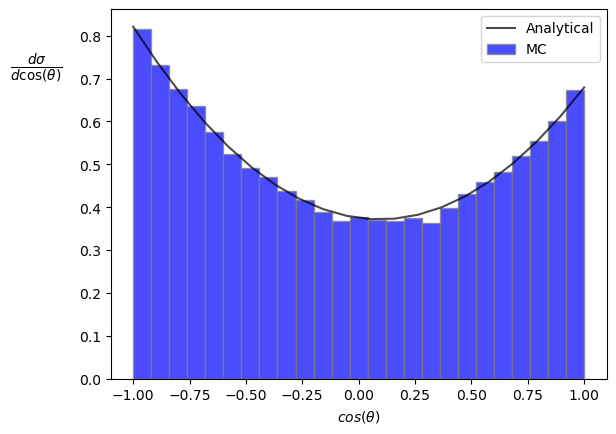

In [34]:
def func(n, x):
    return n * (1 / analytic) * (A0 * (1 + x ** 2) + A1 * x)
fig, ax = plt.subplots()
ps = np.linspace(-1, 1, 20)
y = func((np.pi * alpha ** 2) / (2 * hats), ps) 
ax.plot(ps, y, color = 'black', alpha = 0.7, label = 'Analytical')
ax.hist(x = PScosth, bins = 25, color = 'blue', density = 'True', alpha = 0.7, edgecolor = 'gray', label = 'MC')
plt.xlabel(r'$cos(\theta)$')
plt.ylabel(r'$\frac{d\sigma}{d\cos(\theta)}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.8)
plt.legend()
plt.show()

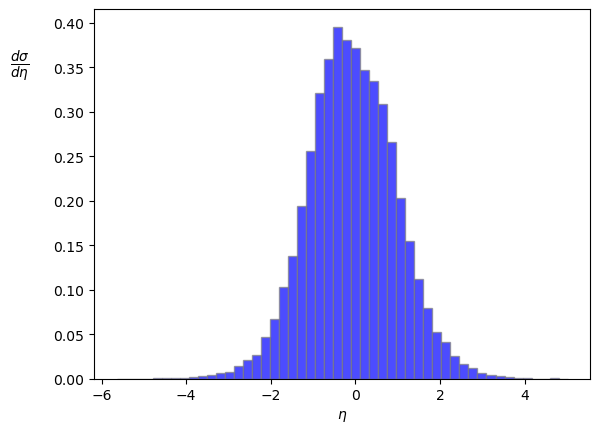

In [35]:
fig, ax = plt.subplots()
plt.hist(x = rap_P, bins = 50, density = 'True', color = 'blue', alpha = 0.7, edgecolor = 'gray', label = 'MC')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$\frac{d\sigma}{d\eta}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.8)
plt.show()

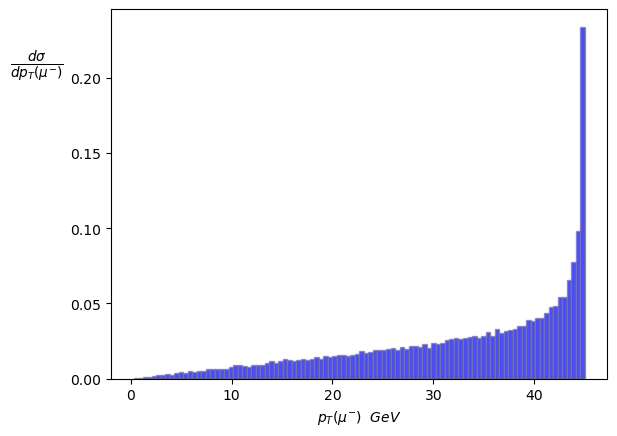

In [36]:
fig, ax = plt.subplots()
plt.hist(x = ptrans_P, bins = 100, density = 'True', color = 'blue', edgecolor = 'gray', alpha = 0.7, label = 'MC')
plt.xlabel(r'$p_T(\mu^{-})$  $GeV$')
plt.ylabel(r'$\frac{d\sigma}{dp_T(\mu^{-})}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.8)
plt.show()

In [37]:
costh_pos = []
costh_neg = []
for i in PScosth:
    if i > 0:
        costh_pos += [i]
    else:
        costh_neg += [i]

w_pos = 2 * dsigma(np.array(costh_pos))
w_neg = 2 * dsigma(np.array(costh_neg))
sigma_pos = (np.sum(w_pos) / len(w_pos)) * pb_convert
sigma_neg = (np.sum(w_neg) / len(w_neg)) * pb_convert
assym = (sigma_pos - sigma_neg) / (sigma_pos + sigma_neg)
print(assym) # there is more asymmetry here ofcourse

-0.0812500928920003
